# EDA on displacement data

### Imports

In [35]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from libpysal.weights import Queen, KNN, DistanceBand
from esda.moran import Moran, Moran_Local


df = pd.read_csv('displacement_data.csv')


### First EDA

In [36]:
#df and displacement variable

displacement = "new_displacement"
print(df.shape)
print(df.dtypes)
print("min,max=", df[displacement].min(),",", df[displacement].max())

(6482, 5)
iso3                  str
year                int64
start_date            str
new_displacement    int64
hazard_type_name      str
dtype: object
min,max= 1 , 7245490


In [37]:
# statistic of displacement

df[displacement].describe()

count    6.482000e+03
mean     2.923188e+04
std      2.051160e+05
min      1.000000e+00
25%      1.400000e+01
50%      1.000000e+02
75%      1.095750e+03
max      7.245490e+06
Name: new_displacement, dtype: float64

In [38]:
# top events for displacement
top_events = df.sort_values(displacement, ascending = False).head(15) 
top_events

,iso3,year,start_date,new_displacement,hazard_type_name
4755,PAK,2022,2022-06-14,7245490,Flood
191,PHL,2013,2013-11-08,4095280,Storm
4319,PHL,2021,2021-12-11,3947651,Storm
3553,CHN,2020,2020-06-01,3760000,Flood
5245,PHL,2022,2022-10-27,3012686,Storm
484,PHL,2014,2014-07-15,2994054,Storm
3046,IND,2019,2019-06-08,2623349,Flood
774,NPL,2015,2015-04-25,2622733,Earthquake
978,PHL,2016,2016-12-23,2592251,Storm
3226,BGD,2020,2020-05-16,2508819,Storm


In [39]:
# displacement events per country per year
country_year = (
    df.groupby(["iso3", "year"], as_index=False)
      .agg(
          event_count=("new_displacement", "count"),
          displacement_per_year=("new_displacement", "sum")
      )
)

country_year.head()


,iso3,year,event_count,displacement_per_year
0,BGD,2013,4,1159829
1,BGD,2014,2,543000
2,BGD,2015,5,531099
3,BGD,2016,3,613710
4,BGD,2017,7,946119


In [40]:
# Compute per-year descriptive statistics
stats_by_year = (
    df.groupby('year')['new_displacement']
      .describe()
)

stats_by_year


,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,237.0,82795.641350,338802.979871,1.0,69.0,700.0,14251.00,4095280.0
2014,325.0,51084.680000,226762.323492,2.0,50.0,499.0,6464.00,2994054.0
2015,253.0,63512.833992,266609.637147,3.0,32.0,316.0,4792.00,2622733.0
2016,277.0,71524.447653,287981.719611,4.0,135.0,820.0,8100.00,2592251.0
2017,415.0,27329.267470,129508.384032,2.0,100.0,600.0,3941.50,1620000.0
2018,766.0,16097.992167,119894.607359,1.0,11.0,68.0,593.50,1967258.0
2019,897.0,21554.435897,175900.515946,1.0,5.0,35.0,266.00,2623349.0
2020,664.0,31730.269578,233197.150625,1.0,14.0,112.0,1090.25,3760000.0
2021,506.0,37273.351779,230882.677658,1.0,23.0,249.5,2848.00,3947651.0


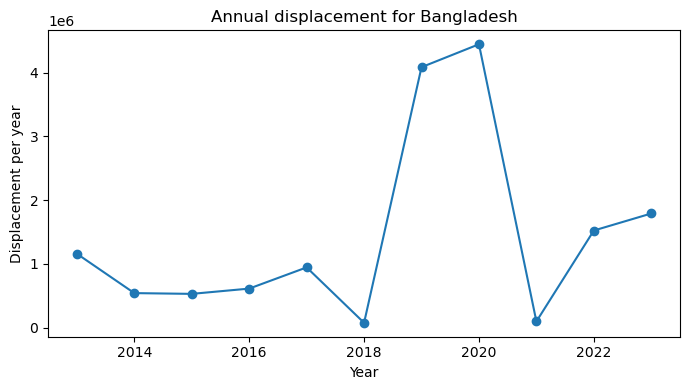

In [41]:
#graph just for BGD 
bgd_data = country_year[country_year["iso3"] == "BGD"]

plt.figure(figsize=(7,4))
plt.plot(bgd_data["year"], bgd_data["displacement_per_year"], marker='o')
plt.title("Annual displacement for Bangladesh")
plt.xlabel("Year")
plt.ylabel("Displacement per year")
plt.tight_layout()
plt.show()

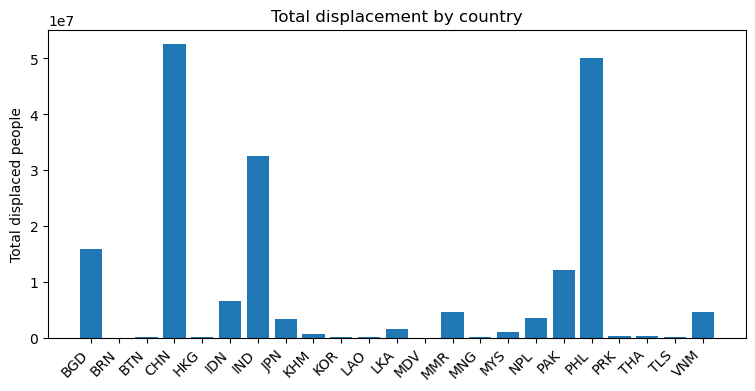

In [42]:
# total displacement per country

country = (
    df.groupby(["iso3"], as_index=False)[displacement]
      .sum()
      .rename(columns={displacement: "displacement_per_country"})
)

plt.figure(figsize=(9,4))
plt.bar(country["iso3"], country["displacement_per_country"])
plt.xticks(rotation=45, ha="right")
plt.title("Total displacement by country")
plt.ylabel("Total displaced people")
plt.show()

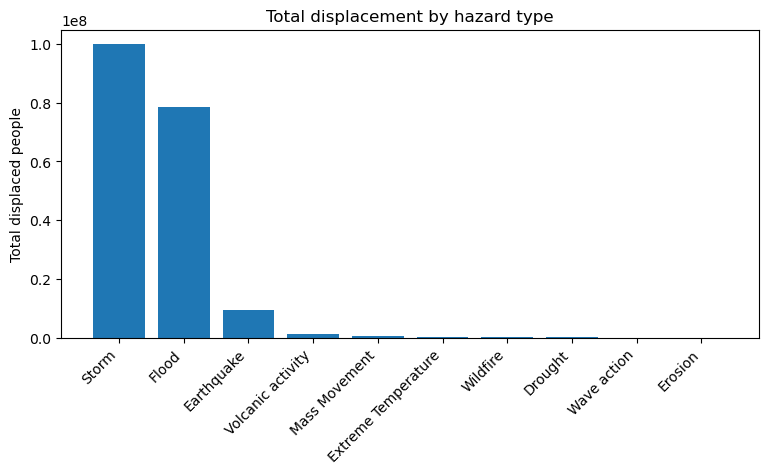

In [43]:
hazard = (
    df.groupby("hazard_type_name", as_index=False)[displacement]
      .agg(
          total_displacement="sum",
          mean_event_displacement="mean",
          median_event_displacement="median",
          event_count="count"
      )
      .sort_values("total_displacement", ascending=False)
)

plt.figure(figsize=(9,4))
plt.bar(hazard["hazard_type_name"], hazard["total_displacement"])
plt.xticks(rotation=45, ha="right")
plt.title("Total displacement by hazard type")
plt.ylabel("Total displaced people")
plt.show()

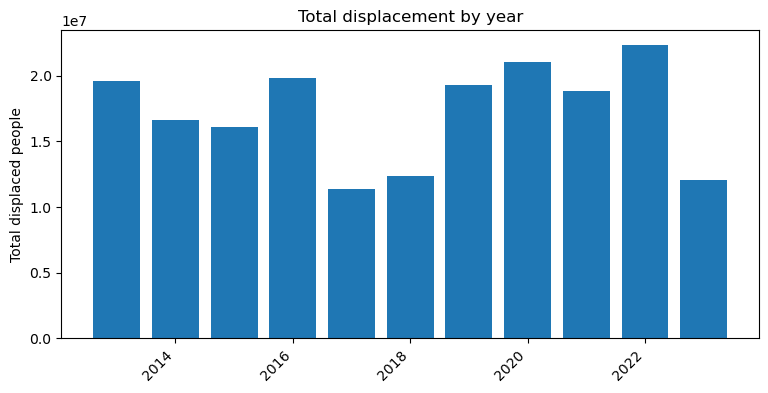

In [44]:
# total displacement per year
year = (
    df.groupby("year", as_index=False)[displacement]
      .sum()
      .rename(columns={displacement: "global_displacement"})
)

plt.figure(figsize=(9,4))
plt.bar(year["year"], year["global_displacement"])
plt.xticks(rotation=45, ha="right")
plt.title("Total displacement by year")
plt.ylabel("Total displaced people")
plt.show()


#### Event frequency map

In [45]:
haz_country = (
    df.groupby(["iso3", "hazard_type_name"], as_index=False)
      .agg(
          event_count=("new_displacement", "count")
      )
)

haz_country.head()


,iso3,hazard_type_name,event_count
0,BGD,Earthquake,1
1,BGD,Erosion,17
2,BGD,Flood,35
3,BGD,Mass Movement,22
4,BGD,Storm,30


In [46]:
# Create a table: countries (rows) x hazard types (columns)
hazard_by_country = haz_country.pivot_table(
    index="iso3",
    columns="hazard_type_name",
    values="event_count",
    fill_value=0
)

# Convert to integers for cleaner display
hazard_by_country = hazard_by_country.astype(int)

# Sort by total count
hazard_by_country['Total'] = hazard_by_country.sum(axis=1)
hazard_by_country = hazard_by_country.sort_values('Total', ascending=False)

hazard_by_country

hazard_type_name,Drought,Earthquake,Erosion,Extreme Temperature,Flood,Mass Movement,Storm,Volcanic activity,Wave action,Wildfire,Total
iso3,,,,,,,,,,,
IDN,2,75,0,0,1091,317,578,33,8,13,2117
MYS,0,0,0,0,546,17,19,0,0,2,584
PHL,1,34,1,2,261,43,210,9,4,1,566
CHN,0,73,0,7,231,46,182,0,0,6,545
LKA,0,0,5,0,158,69,182,0,0,5,419
NPL,0,8,0,0,124,128,88,0,0,14,362
MMR,0,0,2,0,89,112,142,0,0,1,346
IND,1,4,0,0,221,31,85,0,0,2,344
VNM,0,1,0,0,74,73,189,0,0,1,338


In [47]:
world = gpd.read_file("110m_cultural//ne_110m_admin_0_countries.shp")

gdf = world.merge(haz_country, how="left", left_on="ISO_A3", right_on="iso3")

gdf[["NAME", "ISO_A3", "hazard_type_name", "event_count"]].head()


,NAME,ISO_A3,hazard_type_name,event_count
0,Fiji,FJI,NaN,NaN
1,Tanzania,TZA,NaN,NaN
2,W. Sahara,ESH,NaN,NaN
3,Canada,CAN,NaN,NaN
4,United States of America,USA,NaN,NaN


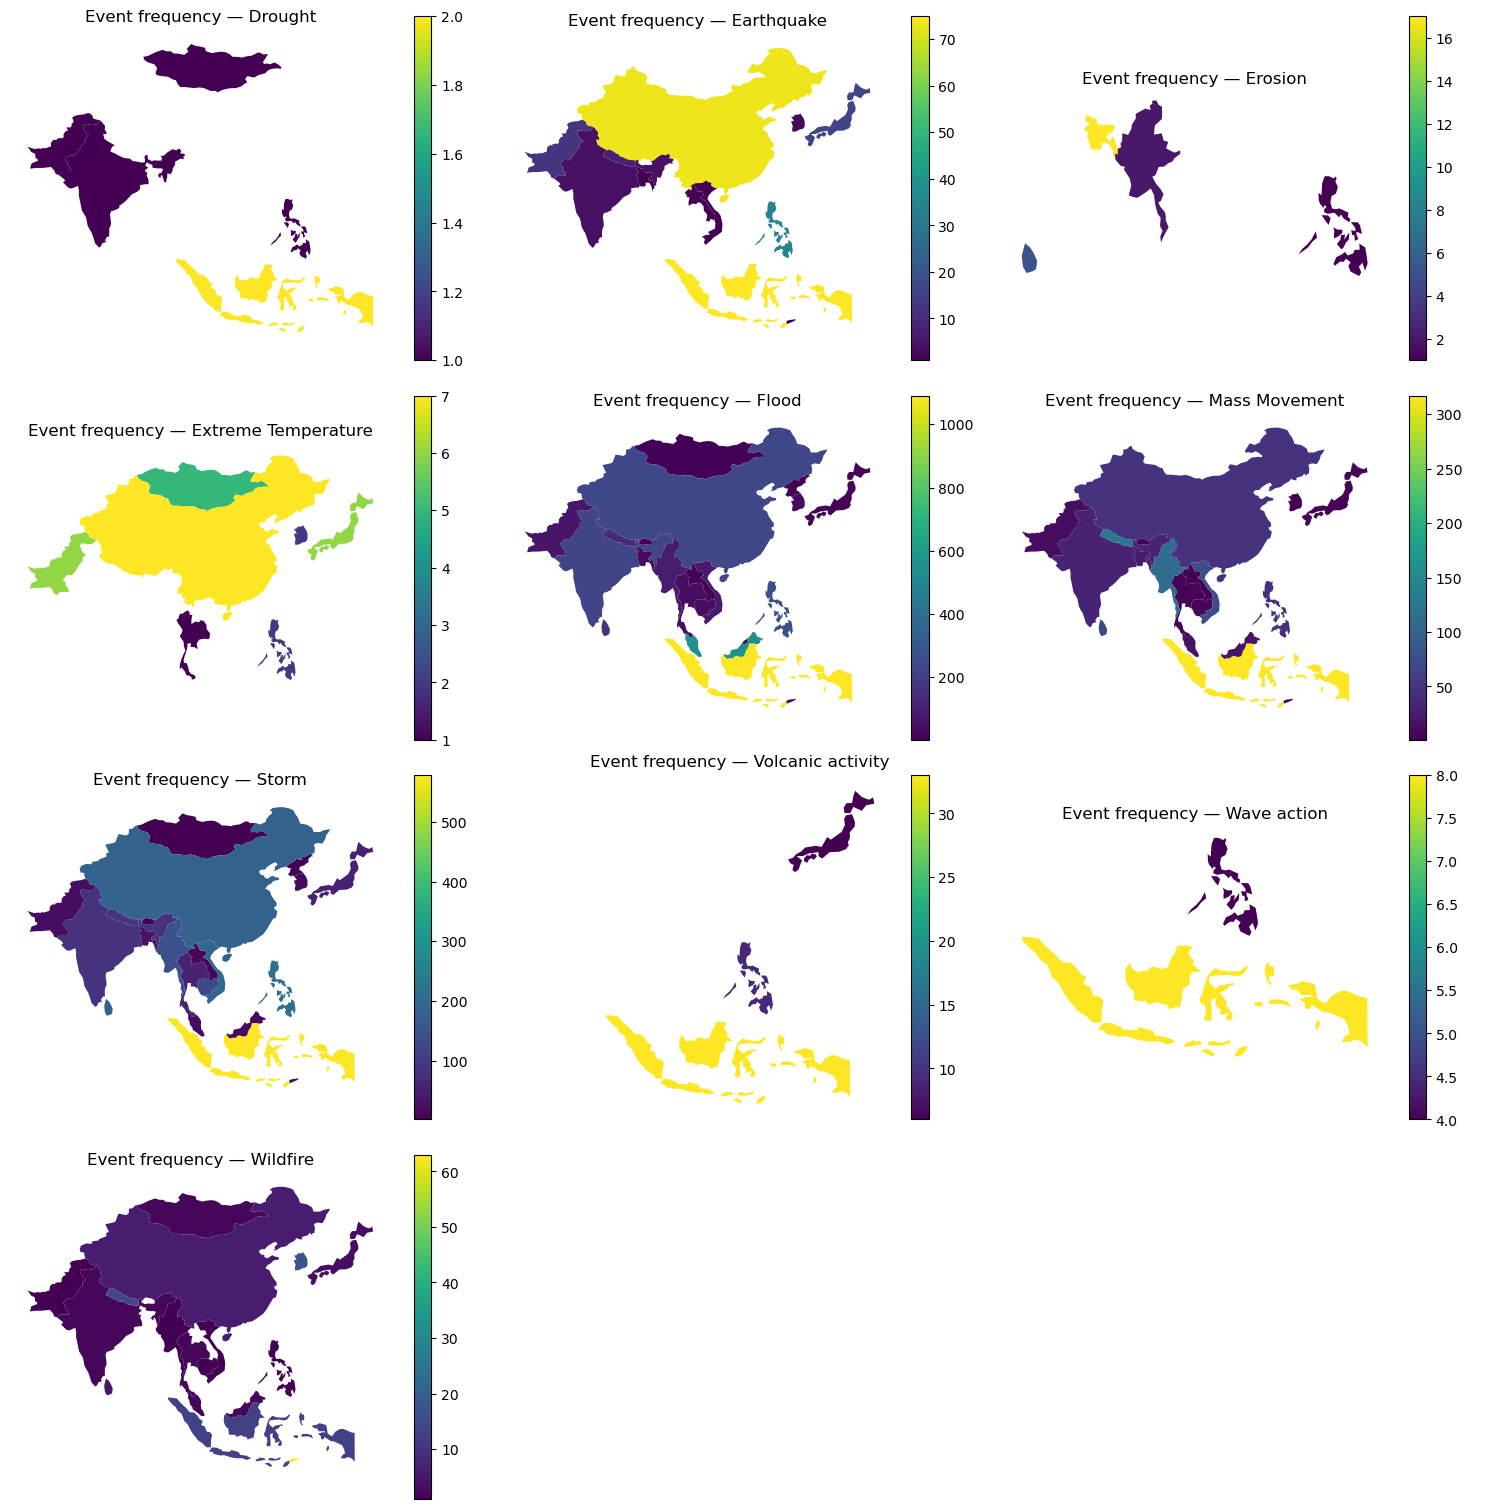

In [48]:
#event frequency on map

hazards = sorted(df["hazard_type_name"].unique())

n = len(hazards)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.8*rows))
axes = np.array(axes).reshape(-1)

for i, hz in enumerate(hazards):
    ax = axes[i]
    sub = gdf[gdf["hazard_type_name"] == hz]
    
    sub.plot(
        column="event_count",
        ax=ax,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ax.set_title(f"Event frequency — {hz}")
    ax.axis("off")


for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### functions

In [49]:
# compute lisa clusters 
def compute_lisa(gdf, variable, weights, p=0.05):
    """
    Computes LISA clusters for a given variable and spatial weights
    """
    x = gdf[variable].values
    x = (x - x.mean()) / x.std()  # standardize

    lisa = Moran_Local(x, weights)
    #lisa = Moran_Local(x, weights, permutations=999, seed=42)


    cluster = np.full(len(gdf), "Not significant", dtype=object)

    sig = lisa.p_sim < p

    cluster[sig & (lisa.q == 1)] = "High-High"
    cluster[sig & (lisa.q == 2)] = "Low-High"
    cluster[sig & (lisa.q == 3)] = "Low-Low"
    cluster[sig & (lisa.q == 4)] = "High-Low"

    return cluster

def compute_lisa_average(gdf, variable, weights, p=0.05, n_runs=40):
    """
    Computes LISA clusters for a given variable and spatial weights,
    repeated n_runs times, returning the most frequent cluster per observation.
    """
    x = gdf[variable].values
    x = (x - x.mean()) / x.std()  # standardize

    # Store cluster labels for each run
    cluster_matrix = []

    for _ in range(n_runs):
        lisa = Moran_Local(x, weights, permutations=999)  
        cluster = np.full(len(gdf), "Not significant", dtype=object)
        sig = lisa.p_sim < p

        cluster[sig & (lisa.q == 1)] = "High-High"
        cluster[sig & (lisa.q == 2)] = "Low-High"
        cluster[sig & (lisa.q == 3)] = "Low-Low"
        cluster[sig & (lisa.q == 4)] = "High-Low"

        cluster_matrix.append(cluster)

    # Convert to DataFrame for easy mode calculation
    cluster_df = pd.DataFrame(np.array(cluster_matrix).T)  # shape: n_obs x n_runs

    # Compute the most frequent cluster per observation
    final_cluster = cluster_df.mode(axis=1)[0].values

    return final_cluster



# plot function
def plot_lisa_map(gdf, cluster_col, title, save_path = None):
    colors = {
        "High-High": "#d7191c",
        "Low-Low": "#2c7bb6",
        "High-Low": "#fdae61",
        "Low-High": "#abd9e9",
        "Not significant": "lightgrey"
    }

    fig, ax = plt.subplots(figsize=(12, 8))

    gdf.plot(
        ax=ax,
        color=gdf[cluster_col].map(colors),
        linewidth=0.3,
        edgecolor="black"
    )

    handles = [
        plt.Line2D([0], [0], marker='s', color='w',
                   label=k, markerfacecolor=v, markersize=10)
        for k, v in colors.items()
    ]

    ax.legend(handles=handles, title="LISA cluster", loc="lower left")
    #ax.set_title(title)
    ax.axis("off")

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')


    plt.show()

In [50]:
def plot_value_heatmap(gdf, variable, title, cmap="YlOrRd", figsize=(12,8), save_path=None):
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the GeoDataFrame colored by the variable
    gdf.plot(column=variable, ax=ax, cmap=cmap, legend=True, edgecolor="black", linewidth=0.3)
    
    #ax.set_title(title, fontsize=16)
    ax.axis("off")
    
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    
    plt.show()

### Most frequent hazard per country, map

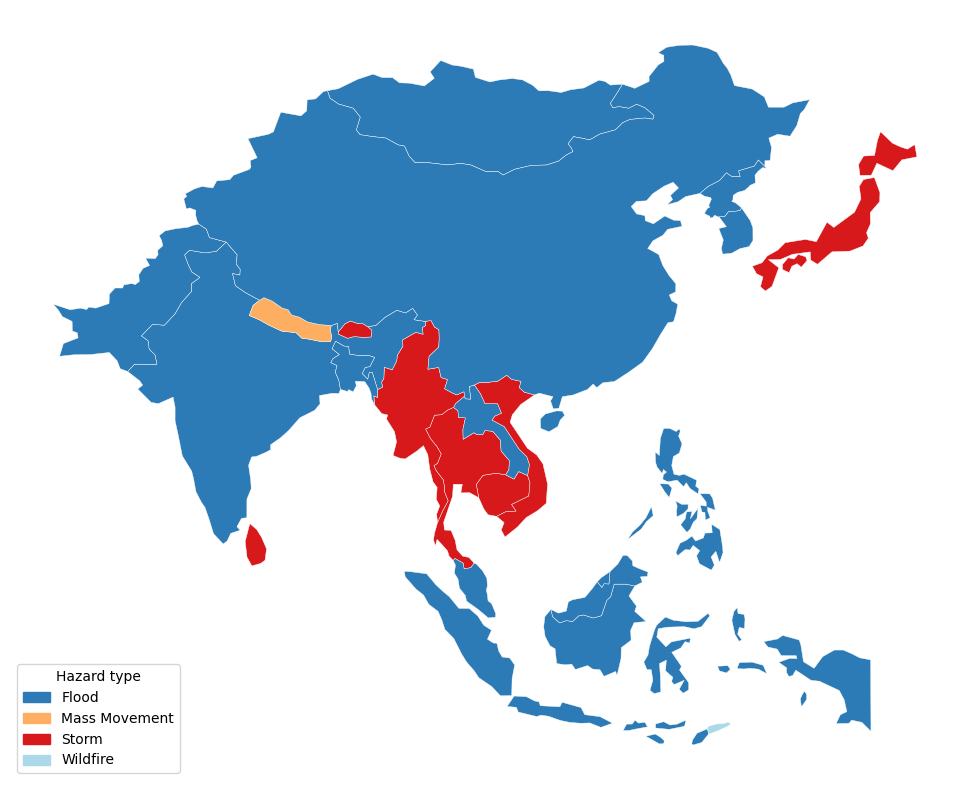

In [51]:
# most frequent hazard per country
agg_asia = (
    df.groupby(["iso3", "hazard_type_name"], as_index=False)
      .agg(event_count=("new_displacement", "count"))
)

# dominant hazard by frequency per country
idx = agg_asia.groupby("iso3")["event_count"].idxmax()
dom_asia = agg_asia.loc[idx].copy()

# Asia geometries
world = gpd.read_file("110m_cultural//ne_110m_admin_0_countries.shp")
asia = world[world["CONTINENT"] == "Asia"].copy()

asia_gdf = asia.merge(dom_asia, how="left", left_on="ISO_A3", right_on="iso3")
# keep countries with data
asia_gdf = asia_gdf[asia_gdf["event_count"].notna() & (asia_gdf["event_count"] > 0)]

# palette by hazard type
hazards = sorted(asia_gdf["hazard_type_name"].dropna().unique())

haz_color = {
    "Flood": (0.173, 0.482, 0.714, 1.0),  
    "Mass Movement": (0.992, 0.682, 0.380, 1.0),  
    "Wildfire": (0.671, 0.851, 0.914, 1.0),   
    "Storm": (0.843, 0.098, 0.110, 1.0), 
}

# fallback for any other hazards
default_cmap = plt.get_cmap("tab10")
other_hazards = [h for h in hazards if h not in haz_color]
for i, h in enumerate(sorted(other_hazards)):
    haz_color[h] = default_cmap(i % 10)

# build facecolors
facecolors_asia = [haz_color.get(hz, (0.85, 0.85, 0.85, 1.0)) for hz in asia_gdf["hazard_type_name"]]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

asia_gdf.plot(ax=ax, color=facecolors_asia, edgecolor="white", linewidth=0.3)

# ax.set_title("Most frequent hazard by country — Asia", fontsize=14)
ax.axis("off")


legend_hazards = hazards
patches = [mpatches.Patch(color=haz_color[hz], label=hz) for hz in legend_hazards]
ax.legend(handles=patches, title="Hazard type", loc="lower left", frameon=True)

plt.tight_layout()
plt.show()

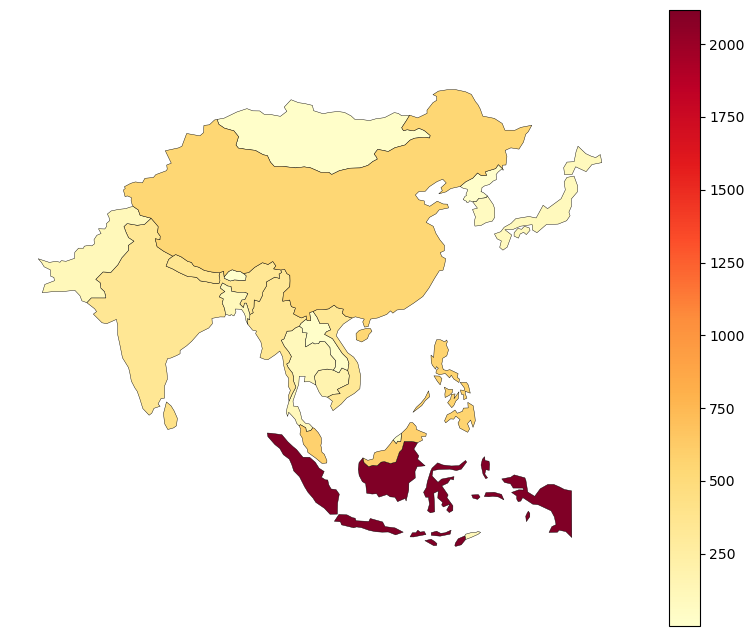

In [52]:
# Heatmap of total events per country in Asia

# Count total events per country
events_per_country = df.groupby('iso3').size().reset_index(name='total_events')

# Load Asia geometries
world = gpd.read_file("110m_cultural//ne_110m_admin_0_countries.shp")
asia = world[world["CONTINENT"] == "Asia"].copy()

# Merge events data with Asia geometries
asia_events_gdf = asia.merge(events_per_country, how="left", left_on="ISO_A3", right_on="iso3")
asia_events_gdf['total_events'] = asia_events_gdf['total_events'].fillna(0)

# Keep only countries with at least 1 event
asia_events_gdf = asia_events_gdf[asia_events_gdf['total_events'] > 0].copy()

# Create heatmap
plot_value_heatmap(asia_events_gdf, 'total_events', 'Total Displacement Events per Country - Asia', cmap="YlOrRd", figsize=(10, 8))

### Moran's I and LISA for 10 year

In [53]:
# 1) Asia boundaries
world = gpd.read_file("110m_cultural//ne_110m_admin_0_countries.shp")
asia = world[world["CONTINENT"] == "Asia"].copy()

# 2) just Asia
asia_iso3 = set(asia["ISO_A3"])
df = df[df["iso3"].isin(asia_iso3)].copy()

# 3) count events per iso3 x hazard
counts = (df.groupby(["iso3", "hazard_type_name"])
              .size()
              .reset_index(name="event_count"))

# 4) pivot: rows=iso3, columns=hazard, values=event_count
pivot_counts = counts.pivot(index="iso3", columns="hazard_type_name", values="event_count").fillna(0)

# 5) merge
gdf = asia.merge(pivot_counts.reset_index(), how="left", left_on="ISO_A3", right_on="iso3")

# if a country does not appear in the 2023 dataset -> NaN -> set to 0
hazard_cols = list(pivot_counts.columns)
gdf[hazard_cols] = gdf[hazard_cols].fillna(0)

# keep only if at least 1 event
gdf["Total_events"] = gdf[hazard_cols].sum(axis=1)
gdf = gdf[gdf["Total_events"] > 0].copy()

gdf[["NAME","ISO_A3","Total_events"]].head()


,NAME,ISO_A3,Total_events
2,Indonesia,IDN,2117.0
3,Timor-Leste,TLS,105.0
13,Cambodia,KHM,176.0
14,Thailand,THA,107.0
15,Laos,LAO,19.0


In [54]:
features = hazard_cols

In [55]:
gdf_m = gdf.to_crs(epsg=3857)  
threshold = 1_900_000  

w_inv_dist = DistanceBand.from_dataframe(
    gdf_m,
    threshold=threshold,
    binary=False,
    alpha=-1.0,           # inverse distance
    silence_warnings=True
)

w_inv_dist.transform = "R"   


c:\Users\viola\anaconda3\Lib\site-packages\scipy\sparse\_data.py:128: RuntimeWarning: divide by zero encountered in power
  return self._with_data(data ** n)


In [56]:
features = hazard_cols  
w = w_inv_dist          

n_runs = 40
results = []

for var in features:
    
    x = gdf[var].values.astype(float)

    if np.std(x) == 0:
        continue

    x = (x - x.mean()) / x.std()

    moran_i_list, expected_i_list, z_list, p_list = [], [], [], []

    for _ in range(n_runs):
        moran = Moran(x, w, permutations=999)
        moran_i_list.append(moran.I)
        expected_i_list.append(moran.EI)
        p_list.append(moran.p_sim)

    results.append({
        "Variable": var,
        "Moran I": np.mean(moran_i_list),
        "Expected I": np.mean(expected_i_list),
        "p-value": np.mean(p_list),
        "Total events": int(gdf[var].sum())
    })

moran_df = pd.DataFrame(results).sort_values("p-value")
moran_df

,Variable,Moran I,Expected I,p-value,Total events
3,Extreme Temperature,0.435046,-0.05,0.016900,29
9,Wildfire,0.133851,-0.05,0.051325,134
5,Mass Movement,-0.199440,-0.05,0.085325,894
8,Wave action,0.082558,-0.05,0.090550,12
6,Storm,-0.202825,-0.05,0.110575,2027
7,Volcanic activity,-0.007187,-0.05,0.187300,48
4,Flood,-0.000145,-0.05,0.262675,3055
1,Earthquake,-0.132375,-0.05,0.311925,229
2,Erosion,-0.044443,-0.05,0.340100,25
0,Drought,-0.070960,-0.05,0.478100,6


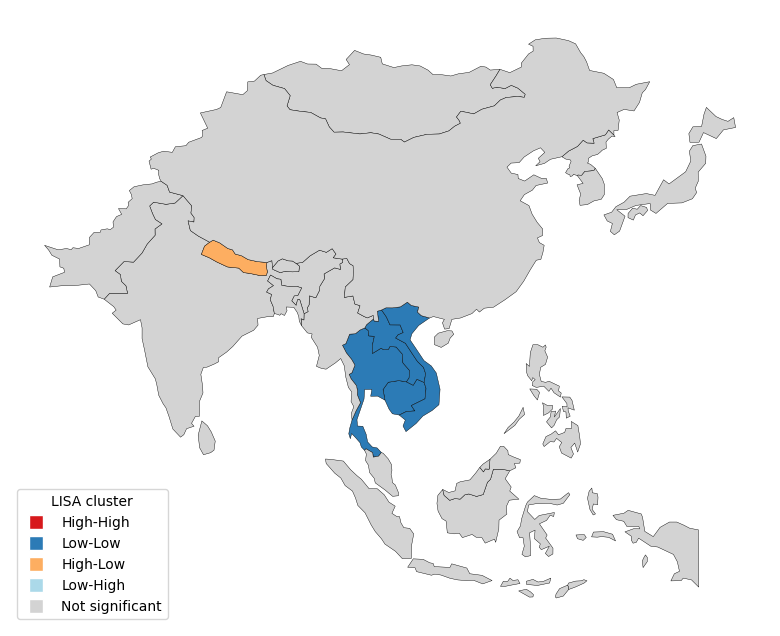

In [57]:
hz = "Wildfire"

gdf["lisa_cluster"] = compute_lisa_average(gdf, hz, w_inv_dist, p=0.05, n_runs=40)

# plot
plot_lisa_map(gdf, "lisa_cluster", title=f"LISA clusters — {hz} event count (Asia, 2023)")


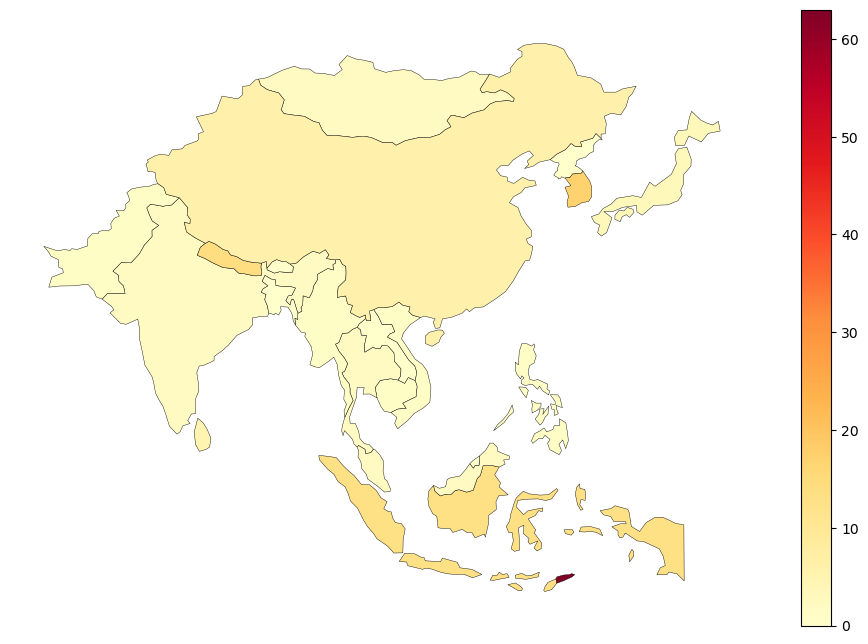

In [58]:
hz = "Wildfire"
plot_value_heatmap(gdf, hz, title=f"{hz} event count (Asia, 2023)", cmap="YlOrRd")

